First, install photonlib. This is a library that contains a useful class definition for lightmaps (aka photon libraries). Each photon library is defined as an axis-aligned bounding box (AABB) and a list of visibilities (aka PTE). These classes contain helpful methods for manipulating and querying the lightmaps.

In [121]:
!pip install scikit-build

Defaulting to user installation because normal site-packages is not writeable


In [120]:
!pip install git+https://github.com/cider-ml/photonlib.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/cider-ml/photonlib.git to /tmp/pip-req-build-l4zyy8_e
  Running command git clone -q https://github.com/cider-ml/photonlib.git /tmp/pip-req-build-l4zyy8_e


In [1]:
# load photon library
from photonlib import PhotonLib

# load the photon library
plib = PhotonLib.load('../data/lxeplib_hv_5mm.h5')
print('voxel ranges [mm]:\n', plib.meta.ranges)
print('num voxels:\n', plib.meta.shape)
print('plib device:\n', plib.device)

[PhotonLib] loading ../data/lxeplib_hv_5mm.h5
[PhotonLib] file loaded
voxel ranges [mm]:
 tensor([[127.5000, 327.5000],
        [232.5000, 432.5000],
        [277.5000, 392.5000]])
num voxels:
 tensor([40, 40, 23])
plib device:
 cpu


You'll notice we're working in pytorch, not numpy. Also, note that the voxel positions range between ~130 to 400 mm. This is because the STL's aren't centered at the origin for whatever reason.

In [40]:
import torch

# can get visibility at any position via
x = torch.tensor([200, 300, 300])
vis = plib.visibility(x)
vis

tensor([0.0226, 0.0026])

If you want to input voxel positions that start at the origin, you can just subtract the minimum x, y, and z values from all the voxel positions:

In [102]:
xbins,ybins,zbins=plib.meta.bin_centers
min_vals = torch.tensor([xbins[0],ybins[0],zbins[0]])

x = torch.tensor([70,65,20]) # 70, 65, 20 mmm from origin
vis = plib.visibility(x+min_vals)
vis

tensor([0.0226, 0.0026])

Note it gives visibilities at both pmts. To combine them, just add them together. We add and not average because both visibilities came from the same initial photons.

In [103]:
tot_vis = plib.visibility(x+min_vals).sum(axis=-1)
tot_vis

tensor(0.0253)

The function `plib.visibility(pos)` above does the following to get visibilities at a set of positions:

In [104]:
pos = x+min_vals

squeeze = False
if len(pos.shape) == 1:
    pos = pos[None,:]
    squeeze = True

vis = torch.zeros(size=(pos.shape[0],plib.n_pmts),dtype=torch.float32).to(plib.device)
mask = plib.meta.contain(pos)
vis[mask] = plib.vis[plib.meta.coord_to_voxel(pos[mask])]
vis.squeeze() if squeeze else vis

tensor([0.0226, 0.0026])

In [112]:
# get visibility at each voxel
v = plib.vis_view
print('plib.vis_view shape:\n', v.shape,'\n')

# alternatively, get a big list of positions and visibilities
v_flattened = plib.vis
positions = plib.meta.voxel_to_coord(range(v_flattened.shape[0]))
print('positions shape:\n', positions.shape)
print('plib.vis shape:\n', v_flattened.shape)

plib.vis_view shape:
 torch.Size([40, 40, 23, 2]) 

positions shape:
 torch.Size([36800, 3])
plib.vis shape:
 torch.Size([36800, 2])


With this out of the way now we can plot the lightmaps.

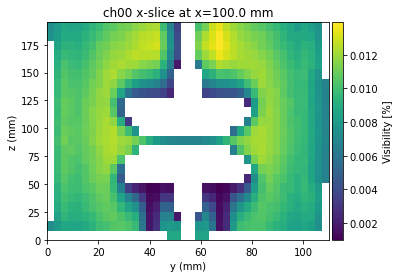

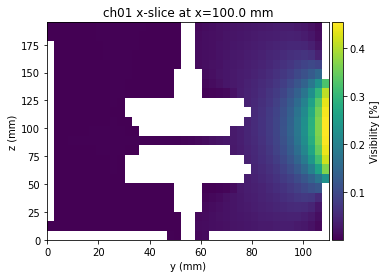

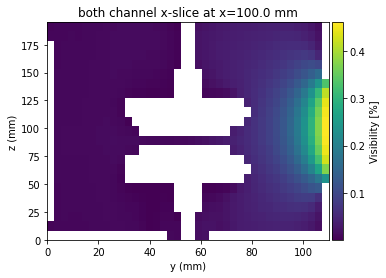

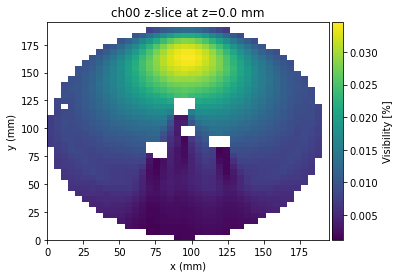

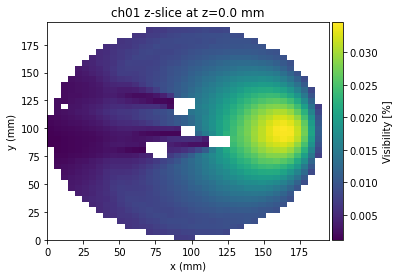

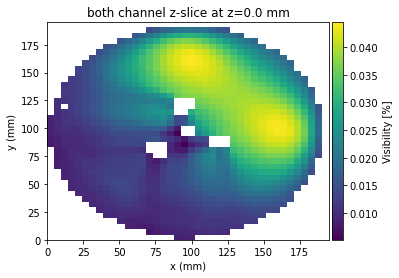

In [69]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# colormap settings
max_v = v.max()
min_v = 5e-4
norm = LogNorm(vmin=min_v, vmax=max_v)
norm = None
colorbarlabel = "Visibility [%]"

# first, plot visibilities between each channel
for ch_id in range(2):

    # get vis at 20th voxel in x direction (x=100 mm)
    xslice = 20
    vis = torch.clone(v[xslice, ..., ch_id])
    vis[vis <= 1e-4] = torch.nan # remove zeros for better visualization

    # get extent from plib.meta.bin_centers
    centers = plib.meta.bin_centers
    extent = [0, centers[2][-1] - centers[2][0], 0, centers[1][-1] - centers[1][0]]
    
    # plot
    plt.imshow(
        vis.T,
        cmap="viridis",
        norm=norm,
        extent=extent,
        aspect="auto",
    )
    
    # labels
    plt.xlabel("y (mm)")
    plt.ylabel("z (mm)")
    plt.title(f"ch{ch_id:02d} x-slice at x={centers[0][xslice]-centers[0][0]} mm")
    plt.colorbar(pad=0.01, label=colorbarlabel)
    plt.show()
    
    
# plot visibilities between both channels
vis = torch.clone(v[xslice, ...].sum(axis=-1))

# remove zeros for better visualization
vis[vis <= 1e-4] = torch.nan

# get extent from plib.meta.bin_centers
centers = plib.meta.bin_centers
extent = [0, centers[2][-1] - centers[2][0], 0, centers[1][-1] - centers[1][0]]

# plot
plt.imshow(vis.T, cmap="viridis", norm=norm, extent=extent, aspect="auto")

# labels
plt.xlabel("y (mm)")
plt.ylabel("z (mm)")
plt.title(f"both channel x-slice at x={centers[0][xslice]-centers[0][0]} mm")
plt.colorbar(pad=0.01, label=colorbarlabel)
plt.show()


# plot visibilities between each channel
for ch_id in range(2):
    
    # get vis at 1st voxel in z direction (z=5 mm)
    zslice = 0
    vis = torch.clone(v[..., zslice, ch_id])
    
    # remove zeros for better visualization
    vis[vis <= 1e-4] = torch.nan
    
    # get extent from plib.meta.bin_centers
    extent = [0, centers[0][-1] - centers[0][0], 0, centers[1][-1] - centers[1][0]]
    
    # plot
    plt.imshow(vis, cmap="viridis", norm=norm, extent=extent, aspect="auto")
    
    # labels
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.title(f"ch{ch_id:02d} z-slice at z={centers[2][zslice]-centers[2][0]} mm")
    plt.colorbar(pad=0.01, label=colorbarlabel)
    plt.show()
    
# plot visibilities between both channels
vis = torch.clone(v[..., zslice, :].sum(axis=-1))

# remove zeros for better visualization
vis[vis <= 1e-4] = torch.nan

# get extent from plib.meta.bin_centers
extent = [0, centers[0][-1] - centers[0][0], 0, centers[1][-1] - centers[1][0]]

# plot
plt.imshow(vis, cmap="viridis", norm=norm, extent=extent, aspect="auto")

# labels
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.title(f"both channel z-slice at z={centers[2][zslice]-centers[2][0]} mm")
plt.colorbar(pad=0.01, label=colorbarlabel)
plt.show()

In [115]:
v_flattened = plib.vis.numpy()
positions = plib.meta.voxel_to_coord(range(v_flattened.shape[0])).numpy()


# pickle positions and visibilities
import pickle

with open('hv_lightmap.pkl', 'wb') as f:
    pickle.dump([positions,v_flattened], f)

In [116]:
pos,vis = pickle.load(open('hv_lightmap.pkl', 'rb'))